In [193]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
from eofs.xarray import Eof
from xarrayutils.utils import linear_trend
import gc
import collections
import statsmodels.api as sm
import scipy
from xeofs.xarray import EOF

In [10]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'

In [11]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [13]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [94]:
model = EOF(flux_clean)

In [95]:
model.solve()

In [96]:
eofs = model.eofs()
pcs = model.pcs()

In [ ]:
reconstr_full = xr.open_dataset(inDirName+
                                interim_data_folder+
                                reconstructions_neofs_path+
                                'Resid_randomized_flux_EOFremoved_n_{}'.
                                format(800))
flux_reconstr = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux

In [80]:
reconstr_full = xr.open_dataset(inDirName+interim_data_folder+'reconstructed_flux_all_modes.nc')
flux_reconstr = reconstr_full.timeMonthly_avg_landIceFreshwaterFlux

In [228]:
%%time
basin = 34
flux_clean.rio.write_crs("epsg:3031",inplace=True);
orig_basin = flux_clean.rio.clip(icems.loc[[basin],'geometry']).squeeze()

CPU times: user 665 ms, sys: 945 ms, total: 1.61 s
Wall time: 1.68 s


In [227]:
%%time
basin = 34
flux_clean.rio.write_crs("epsg:3031",inplace=True);
orig_basin = flux_clean.rio.clip(icems.geometry[[basin]]).squeeze()

CPU times: user 661 ms, sys: 924 ms, total: 1.59 s
Wall time: 1.66 s


In [216]:
icems.loc[[basin]]

,name,tags,object,component,author,constituents,history,geometry
104,Western_Ross,,region,iceshelves,Xylar Asay-Davis,Western_Ross_1; Western_Ross_2,11/18/21 12:31 : lawn-128-61-33-51.lawn.gatech...,"MULTIPOLYGON (((-1500.472 -695217.259, -1500.4..."


In [218]:
icems.geometry[[basin]]

104    MULTIPOLYGON (((-1500.472 -695217.259, -1500.4...
Name: geometry, dtype: geometry

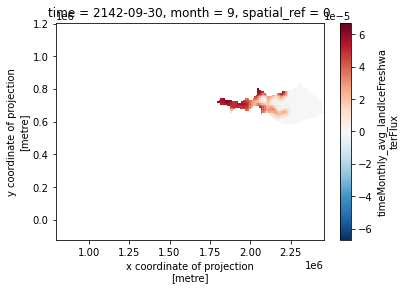

In [191]:
orig_basin[1400].plot()

In [184]:
%%time
basin = 34
flux_clean.rio.write_crs("epsg:3031",inplace=True);
orig_basin = clip_data(flux_clean, basin)

CPU times: user 689 ms, sys: 1 s, total: 1.69 s
Wall time: 1.89 s


In [185]:
%%time
flux_reconstr.rio.write_crs("epsg:3031",inplace=True);
#rec_basin = flux_reconstr.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
rec_basin = clip_data(flux_reconstr, basin)

CPU times: user 734 ms, sys: 2.79 s, total: 3.52 s
Wall time: 4.99 s


In [186]:
%%time
# Remove NaN mask values to 'zoom' into catchment region
orig_basin = orig_basin.dropna('time',how='all')
orig_basin = orig_basin.dropna('y',how='all')
orig_basin = orig_basin.dropna('x',how='all')
orig_basin = orig_basin.drop("month")

rec_basin = rec_basin.dropna('time',how='all')
rec_basin = rec_basin.dropna('y',how='all')
rec_basin = rec_basin.dropna('x',how='all')
rec_basin = rec_basin.drop("month")

CPU times: user 265 ms, sys: 219 ms, total: 484 ms
Wall time: 483 ms


In [178]:
%%time
orig_basin_ts = orig_basin.sum(['y','x'])

CPU times: user 75 ms, sys: 117 ms, total: 192 ms
Wall time: 189 ms


In [149]:
%%time
orig_basin_ts = time_series(orig_basin)

CPU times: user 1.41 s, sys: 2.7 s, total: 4.11 s
Wall time: 5.44 s


In [176]:
%%time
rec_basin_ts = rec_basin.sum(['y','x'])

CPU times: user 1.46 s, sys: 2.9 s, total: 4.36 s
Wall time: 6.14 s


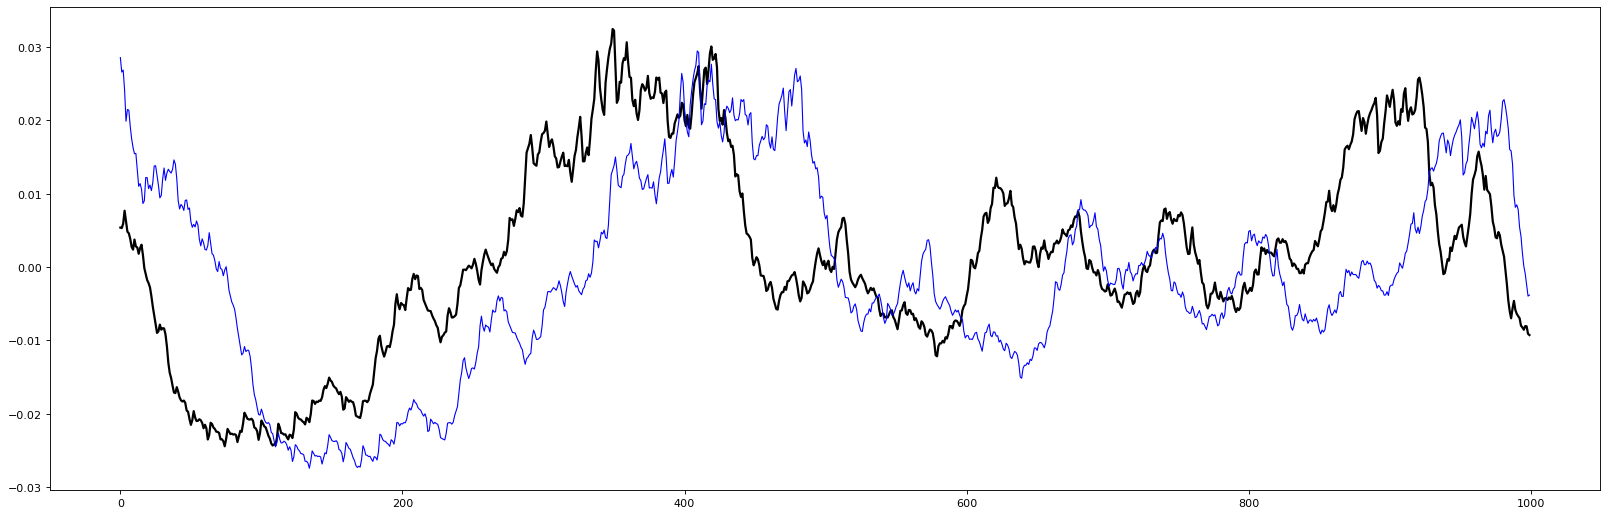

In [177]:
plt.figure(figsize=(25, 8), dpi=80)

t1 = 0
tf = 1000

plt.plot(orig_basin_ts[t1:tf], 'k', linewidth=2, label = 'Model Data')
plt.plot(rec_basin_ts[t1:tf],  'b', linewidth=1, label = 'Emulator Output')

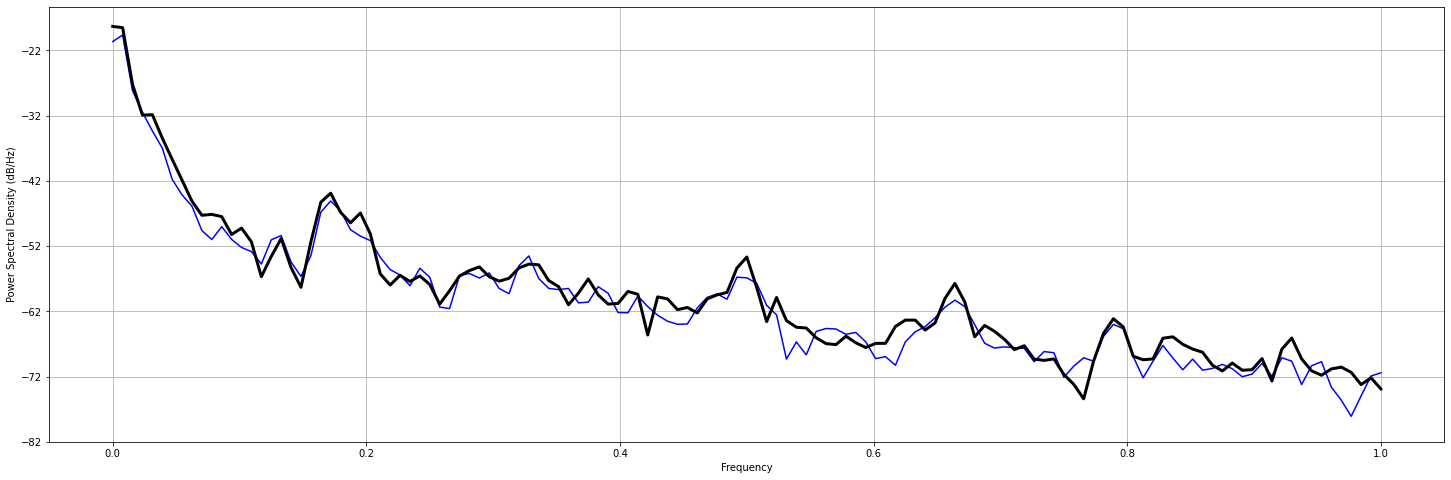

In [126]:
plt.figure(figsize=(25,8))
plt.psd(rec_basin_ts, color = 'b');
plt.psd(orig_basin_ts,label='Original', linewidth=3, color='k');

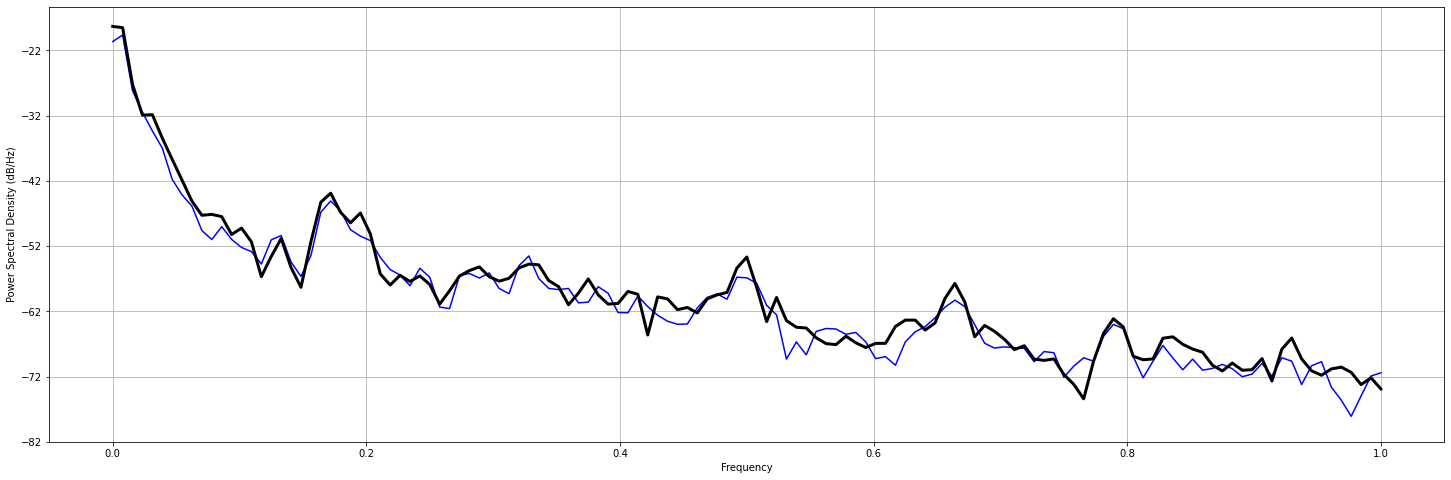

In [127]:
plt.figure(figsize=(25,8))
rec = plt.psd(rec_basin_ts, color = 'b');
orig = plt.psd(orig_basin_ts,label='Original', linewidth=3, color='k');

In [133]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(10*np.log10(rec[0]),10*np.log10(orig[0])))

2.2333081311828313

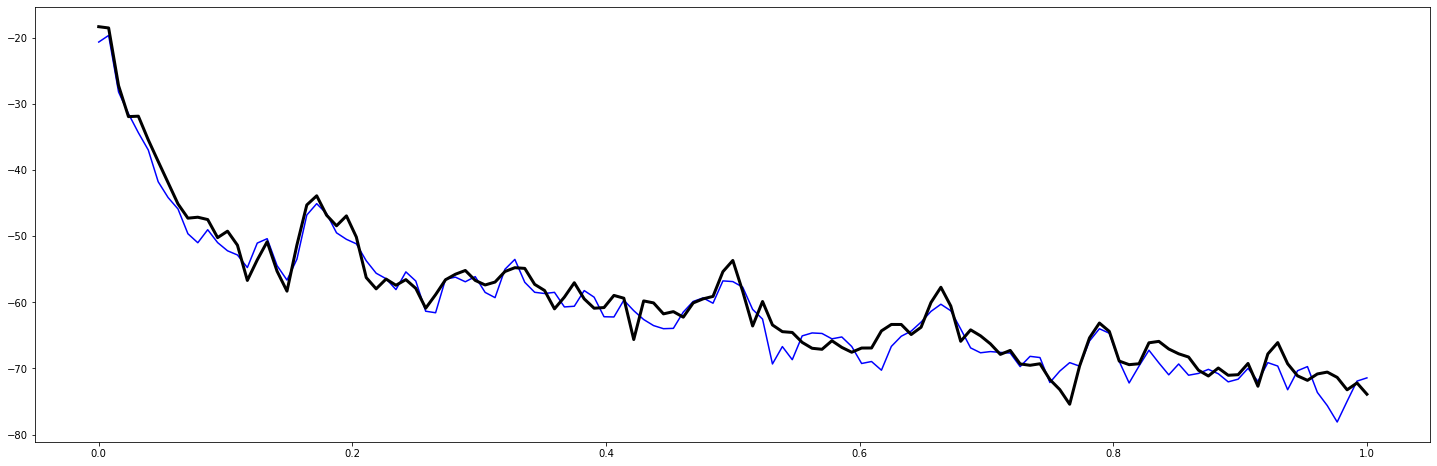

In [134]:
plt.figure(figsize=(25,8))
plt.plot(rec[1], 10*np.log10(rec[0]), color = 'b')
plt.plot(orig[1], 10*np.log10(orig[0]), label='Original', linewidth=3, color='k')

In [197]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'])
    clipped_data = clipped_data.dropna('time',how='all')
    clipped_data = clipped_data.dropna('y',how='all')
    clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

In [180]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [195]:
rioxarray.show_versions()

rioxarray (0.10.1) deps:
  rasterio: 1.2.10
    xarray: 0.21.1
      GDAL: 3.4.1

Other python deps:
     scipy: 1.8.0
    pyproj: 3.3.0

System:
    python: 3.10.2 | packaged by conda-forge | (main, Feb  1 2022, 19:30:18) [Clang 11.1.0 ]
executable: /Users/smurugan9/opt/anaconda3/envs/aislens/bin/python
   machine: macOS-12.5-x86_64-i386-64bit


Calculated for basin..Prince_Harald
deleting interim variables
Calculated for basin..Publications
deleting interim variables
Calculated for basin..Quar
deleting interim variables


/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7090: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7090: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)


Calculated for basin..Rayner_Thyer
deleting interim variables
Calculated for basin..Rennick
deleting interim variables


/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7090: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7090: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)


Calculated for basin..Richter
deleting interim variables
Calculated for basin..Riiser-Larsen
deleting interim variables
Calculated for basin..Ronne
deleting interim variables
Calculated for basin..Western_Ross
deleting interim variables
CPU times: user 13.6 s, sys: 34.6 s, total: 48.2 s
Wall time: 56.6 s


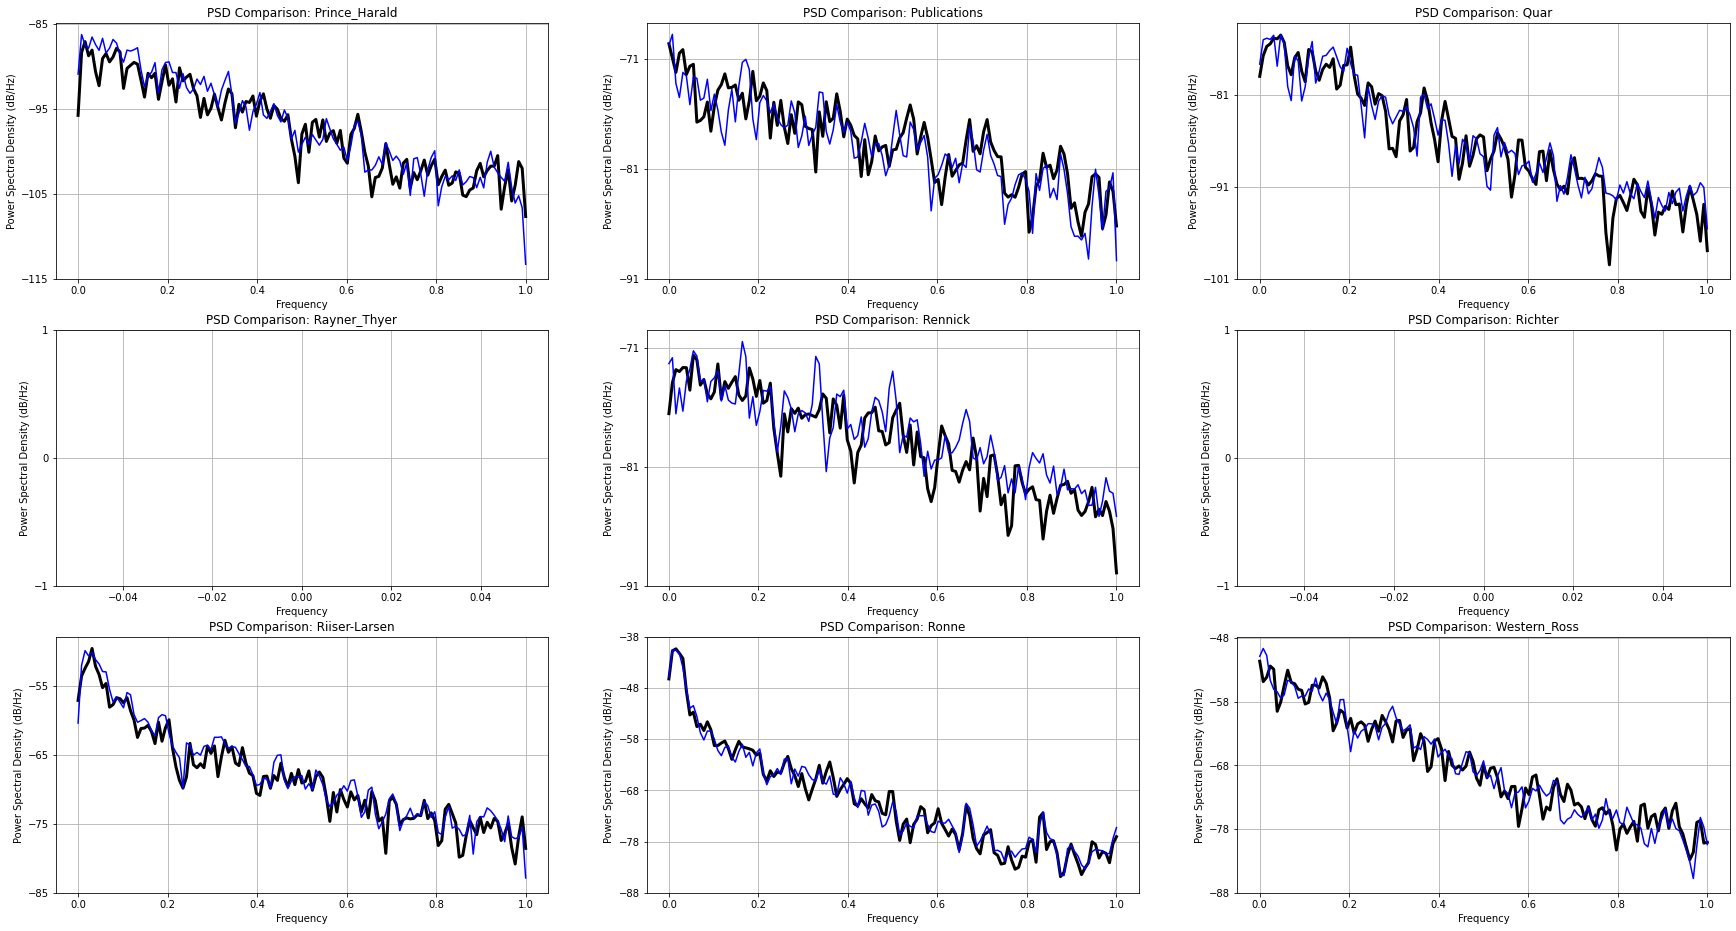

In [198]:
%%time
flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr.rio.write_crs("epsg:3031",inplace=True);

fig, axs = plt.subplots(3,3,figsize=(30,16))
axs=axs.ravel()

for basin in range(96,105):
    orig_basin = clip_data(flux_clean, basin)
    rec_basin = clip_data(flux_reconstr, basin)
    orig_basin_ts = time_series(orig_basin)
    rec_basin_ts = time_series(rec_basin)
    axs[basin-96].psd(orig_basin_ts,label='Original', linewidth=3, color='k');
    axs[basin-96].psd(rec_basin_ts, color = 'b');
    axs[basin-96].set_title('PSD Comparison: {}'.format(icems.name.values[basin]))
    print('Calculated for basin..{}'.format(icems.name.values[basin]))
    del orig_basin, rec_basin, orig_basin_ts, rec_basin_ts 
    print('deleting interim variables')
    gc.collect()

In [ ]:
flux_clean.rio.write_crs("epsg:3031",inplace=True);
flux_reconstr.rio.write_crs("epsg:3031",inplace=True);

plt.figure(figsize=(25,8))

for basin in range(33,133):
    orig_basin = flux_clean.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
    rec_basin = flux_reconstr.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
    # Remove NaN mask values to 'zoom' into catchment region
    orig_basin = orig_basin.dropna('time',how='all')
    orig_basin = orig_basin.dropna('y',how='all')
    orig_basin = orig_basin.dropna('x',how='all')
    orig_basin = orig_basin.drop("month")
    rec_basin = rec_basin.dropna('time',how='all')
    rec_basin = rec_basin.dropna('y',how='all')
    rec_basin = rec_basin.dropna('x',how='all')
    rec_basin = rec_basin.drop("month")
    orig_basin_ts = orig_basin.sum(['y','x'])
    rec_basin_ts = rec_basin.sum(['y','x'])
    plt.psd(orig_basin_ts,label='Original', linewidth=3, color='k');
    plt.psd(rec_basin_ts, color = 'b');
    plt.title('PSD Comparison: {}'.format(icems.name.values[basin]))
    plt.savefig(inDirName+figures_folderpath+'psd-comparison-800/{}'.format(icems.name.values[basin]))
    print('Calculated and saved for basin..{}'.format(icems.name.values[basin]))
    del orig_basin, rec_basin, orig_basin_ts, rec_basin_ts 
    plt.clf()
    print('deleting interim variables')
    gc.collect()

In [ ]:
# LIST OF ALL CATCHMENT BASINS
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(icems.name)